In [1]:
# import torch
# from PIL import Image
# import torchvision.transforms as T

# # Charger le modèle YOLOv5
# model = torch.hub.load('yolov5', 'custom', path='models/best_yolo_corner_detection.pt', source='local')  
# model.eval() 
# imgs = ["board_exemple.jpg"]  # batch of images
# results = model(imgs)
# print("voici ;" , results)
# results.tolist()
# print(results.xywh)
# results.show()  

In [2]:
%matplotlib inline
import torch
import cv2
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Important de mettre ces lignes car les poids ont été obtenus sur Colab (Linux) 
# donc ne marche pas sur mon pc en local qui est Windows. D'où l'utilisation de ces lignes
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [4]:
def afficher_position(image, liste_coordonnees, label="Position"):
    """
    Affiche des points sur une image aux coordonnées spécifiées.
    
    :param image: Image d'origine où les points seront tracés.
    :param liste_coordonnees: Liste des coordonnées sous la forme [(x1, y1), (x2, y2), ...].
    :param label: Texte à afficher près de chaque point (par défaut "Position").
    """
    # Parcourir chaque point dans la liste des coordonnées
    for idx, (x, y) in enumerate(liste_coordonnees):
        # Convertir les coordonnées en entiers pour l'affichage
        x, y = int(x), int(y)
        
        # Dessiner un cercle à chaque point de coordonnées
        cv2.circle(image, (x, y), 10, (255, 0, 0), -1)
        
        # Annoter chaque point avec un label unique
        cv2.putText(image, f"{label} {idx+1}", (x + 15, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    # Afficher l'image avec les annotations
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image avec annotations de positions")
    plt.axis('off')
    plt.show()

In [5]:
def find_corners_with_yolo(model_weights_path, img_path):
        # Charger le modèle YOLOv5
    model = torch.hub.load('yolov5', 'custom', path=model_weights_path, source='local')
    model.eval()
    results = model([img_path])

    # Extraire les coordonnées des bounding boxes
    corner_points = results.xywh[0].cpu().numpy()  # Liste des bounding boxes sous forme [x, y, w, h]
    corners = []
    for box in corner_points:
        # Les coordonnées x et y sont les centres
        x_center = int(box[0])
        y_center = int(box[1])
        corners.append((x_center, y_center))
        
    # Assurer que les coins sont dans l'ordre (haut-gauche, haut-droit, bas-gauche, bas-droit)
    # Trier d'abord par y (haut-bas), puis par x (gauche-droite)
    corners = sorted(corners, key=lambda p: (p[1], p[0]))

    return corners

In [6]:
model_weights_path = 'models/best_yolo_corner_detection.pt'
img_path = "board_exemple_4.jpg"
img = cv2.imread(img_path)

corners = find_corners_with_yolo(model_weights_path, img)

# Dessiner les points sur l'image
for c in corners:
    cv2.circle(img, (c[0], c[1]), 5, (0, 255, 255), -1)  # rouge pour chaque coin

# Afficher l'image avec les points centraux des corners
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Corners détectés")
plt.axis('off')
plt.show()

YOLOv5  v7.0-378-g2f74455a Python-3.10.5 torch-2.2.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


## Partie 2 : Détection des pièces

In [7]:
def find_pieces_boxes(model_path, img_path):
    # Charger le modèle YOLOv5
    model = torch.hub.load('yolov5', 'custom', path=model_path, source='local')  
    model.eval() 
    
    # Charger l'image
    img = cv2.imread(img_path)
    results = model([img_path])
    
    # Extraire les coordonnées des bounding boxes
    boxes = results.xyxy[0].cpu().numpy()  # Liste des bounding boxes sous forme [x1, y1, x2, y2, confidence, class]
    
    return boxes 

model_pieces_detection_weights_path = 'models/best_yolov5x_pieces_detection.pt'
boxes = find_pieces_boxes(model_pieces_detection_weights_path, img_path)

# Dessiner les bounding boxes sans les labels
for box in boxes:
    x1, y1, x2, y2 = map(int, box[:4])  # Coordonnées de la bounding box
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Rectangle bleu, épaisseur 2

# Afficher l'image avec les bounding boxes sans labels
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Bounding Boxes sans Labels")
plt.axis('off')
plt.show()

print(boxes)

pieces_coordinates = []
# Dessiner les points sur l'image
for box in boxes:
    
    delta = abs(box[2]-box[0])/2
    x = int(box[0] + delta)
    y = int(abs(box[3]- delta))
    
    
    # De la forme [x, y, proba, classe]
    pieces_coordinates.append([x, y, box[4], box[5]])
    cv2.circle(img, (x, y), 5, (0, 0, 255), -1)  # rouge pour chaque coin

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Corners détectés")
plt.axis('off')
plt.show()

YOLOv5  v7.0-378-g2f74455a Python-3.10.5 torch-2.2.0+cu118 CPU

Fusing layers... 
Model summary: 322 layers, 86254162 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 


[[     134.22      150.34      160.92      207.17      0.8982           7]
 [     52.136      129.22      83.237         208     0.87779           8]
 [     65.297      29.873      90.741      91.175     0.86972           7]
 [     274.39      119.56       294.3      165.44     0.86955           4]
 [     81.309      298.81      112.02      359.95     0.86759           9]
 [     194.05      48.425      213.96      93.926     0.85647           4]
 [     162.49      78.083      183.88      125.44     0.85613          10]
 [     306.66      88.234      332.76      162.38     0.85201           2]
 [     296.22      301.47      320.88      350.14     0.85126           4]
 [     214.47       252.7         236      301.67     0.84714           4]
 [     91.084      252.54      115.66      302.15     0.84677          10]
 [      103.1      45.707      123.36      90.476     0.84569          10]
 [     241.77      200.93         263      247.73     0.83937           4]
 [     319.25      194.43

# Partie 3 : redresser l'image avec les corners

In [8]:
def redresser_image(img_path, corners, pieces_coordinates, output_size):
    # Vérifiez que nous avons exactement quatre points
    if len(corners) == 4:
        # Organiser les points pour perspective transform
        corners = np.array([corners[0], corners[1], corners[2], corners[3]], dtype="float32")
        
        # Points de destination pour redresser en carré (
        # x output_size)
        dst_pts = np.array([[0, 0], [output_size, 0], [output_size, output_size], [0, output_size]], dtype="float32")

        # Calculer la transformation de perspective
        M = cv2.getPerspectiveTransform(corners, dst_pts)
        image_redressee = cv2.warpPerspective(cv2.imread(img_path), M, (output_size, output_size))
        
        # Transformer les coordonnées des pièces
        pieces_coordinates_format = np.array([[(piece[0], piece[1]) for piece in pieces_coordinates]], dtype="float32")
        new_pieces_coordinates = cv2.perspectiveTransform(pieces_coordinates_format, M)[0]  # Appliquez la transformation  
        
        # On remet la proba et le nom de la pièce
        new_pieces_coordinates = [[p[0], p[1], pieces_coordinates[i][2], pieces_coordinates[i][3]] for i, p in enumerate(new_pieces_coordinates)]

        return image_redressee, new_pieces_coordinates, M  # Retourner l'image redressée et les nouvelles coordonnées
    else:
        print("Erreur : Nombre de coins détectés différent de 4. Veuillez vérifier les résultats du modèle.")
        return None, None
    
# Taille de l'image redressée
output_size = 512
# Redresser l'image et obtenir les nouvelles coordonnées des pièces
image_redressee, new_pieces_coordinates, M = redresser_image(img_path, corners, pieces_coordinates, output_size)

# Dessiner les nouvelles coordonnées sur l'image redressée
for coord in new_pieces_coordinates:
    x, y = int(coord[0]), int(coord[1])
    cv2.circle(image_redressee, (x, y), 5, (0, 255, 0), -1)  # Dessine un point vert sur chaque pièce transformée

# Afficher l'image redressée avec les nouvelles coordonnées
plt.imshow(cv2.cvtColor(image_redressee, cv2.COLOR_BGR2RGB))
plt.title("Image redressée avec coordonnées des pièces")
plt.axis('off')
plt.show()

# Partie 3.5 : Mettre l'échéquier à l'endroit car l'échéquier peut être dans tous les sens 

In [9]:
import cv2 
import numpy as np

def divide_image_into_grid(image):
    height, width = image.shape[:2]
    square_height = height // 8
    square_width = width // 8

    grid = []
    for row in range(8):
        row_squares = []
        for col in range(8):
            x_start = int(col * square_width)
            y_start = int(row * square_height)
            x_end = int(x_start + square_width)
            y_end = int(y_start + square_height)

            square_image = image[y_start:y_end, x_start:x_end]
            row_squares.append(square_image)
        grid.append(row_squares)
    return grid

def determine_square_colors(grid):
    colors = np.zeros((8, 8), dtype=int)
    for row_index, row in enumerate(grid):
        for col_index, square_image in enumerate(row):
            gray_square = cv2.cvtColor(square_image, cv2.COLOR_BGR2GRAY)
            mean_intensity = np.mean(gray_square)
            color = 1 if mean_intensity > 127 else 0  # 1 pour blanc, 0 pour noir
            colors[row_index, col_index] = color
    return colors

def generate_rotations_of_detected_pattern(detected_pattern):
    rotation_0 = detected_pattern
    rotation_90 = np.rot90(detected_pattern, k=1)
    rotation_180 = np.rot90(detected_pattern, k=2)
    rotation_270 = np.rot90(detected_pattern, k=3)

    rotations = {
        '0': rotation_0,
        '90': rotation_90,
        '180': rotation_180,
        '270': rotation_270
    }
    return rotations

def compare_rotated_patterns_to_desired(rotated_patterns):
    
    # Etape 1 : Trouver de combien tourner pour que ça matche avec blanc en bas et noir en haut
    desired_pattern = [[1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1]]
    
    best_match = None
    min_difference = float('inf')

    for rotation_angle, rotated_pattern in rotated_patterns.items():
        difference = np.sum(rotated_pattern != desired_pattern)
        if difference < min_difference:
            min_difference = difference
            best_match = rotation_angle

    return best_match

def adjust_angle_for_rotation(best_rotation):
    angle_map = {
        '0': 0,
        '90': 90,
        '180': 180,
        '270': 270
    }
    return angle_map[best_rotation]

def get_rotation_matrix(image_shape, angle):
    (h, w) = image_shape[:2]
    center = (w / 2, h / 2)
    angle_float = float(angle)
    # Calculer la matrice de rotation (angle positif pour rotation antihoraire)
    M = cv2.getRotationMatrix2D(center, angle_float, 1.0)
    return M, center

def rotate_piece_positions(pieces_coordinates, M):
    # Convertir la liste des coordonnées en array
    points = np.array([[coord[0], coord[1]] for coord in pieces_coordinates], dtype='float32')
    # Ajouter une dimension pour cv2.transform
    points = points.reshape(-1, 1, 2)
    # Appliquer la transformation
    rotated_points = cv2.transform(points, M)
    rotated_pieces_coordinates = []
    for i, coord in enumerate(pieces_coordinates):
        rx, ry = rotated_points[i][0][0], rotated_points[i][0][1]
        rotated_pieces_coordinates.append([rx, ry, coord[2], coord[3]])
    return rotated_pieces_coordinates

def mettre_image_dans_le_bon_sens(image, pieces_coordinates, output_size):
    # Étape 1 : Diviser l'image en grille
    grid = divide_image_into_grid(image)
    
    # Étape 2 : Déterminer la couleur de chaque case
    detected_pattern = determine_square_colors(grid)
    
    # Étape 3 : Générer les rotations du motif détecté
    rotated_patterns = generate_rotations_of_detected_pattern(detected_pattern)
    # Étape 4 : Comparer les rotations du motif détecté avec le motif standard souhaité
    best_rotation = compare_rotated_patterns_to_desired(rotated_patterns)
    print(f"La rotation nécessaire est : {best_rotation} degrés")
    
    # On fait les rotations après ça (de 0 ou 90°)
    # Étape 5 : Calculer la matrice de rotation M
    angle = adjust_angle_for_rotation(best_rotation)
    M_rotation, center = get_rotation_matrix(image.shape, angle)
    
    # Étape 6 : Appliquer la rotation à l'image
    image_tournee = cv2.warpAffine(image, M_rotation, (image.shape[1], image.shape[0]))
    
    # Étape 7 : Appliquer la rotation aux positions des pièces
    new_pieces_coordinates = rotate_piece_positions(pieces_coordinates, M_rotation)
    print("test", new_pieces_coordinates)
    # Partie 2 : déterminer l'orientation exacte de l'échiquier en utilisant uniquement les couleurs des cases des coins ne suffit pas, car cela laisse une ambiguïté entre deux orientations (une rotation de 180 degrés). Pour résoudre ce problème et déterminer l'orientation complète de l'échiquier, il est nécessaire d'utiliser des informations supplémentaires.
    # On suppose alors que l'échequier est au moins dans le bon sens vertical ! 
    # Donc maintenant on regarde la position de rois et on voit si le noir est en bas ou en haut
    
    # Roi noir : index 2
    # Roi blanc : index 8
    
    y_black_king = 0
    y_white_king = 0
    for piece in new_pieces_coordinates:
        if piece[3] == 2 : 
            y_black_king = piece[1]
        elif piece[3] == 8 :
            y_white_king = piece[1]
            
    # On regarde dans quel moitié les rois sont : (on regarde que selon y)
    if y_black_king < output_size//2: # Le roi noir est en haut
        # Donc on a rien besoin de faire 
        other_angle = 0
    else : # Le roi noir est en bas, ce qui n'est pas trop normal
        # Donc on fait une rotation de -180°
        other_angle = -180
        
    # On refait les rotations : 
    M_rotation2, center = get_rotation_matrix(image.shape, other_angle)
    
    # Étape 6 : Appliquer la rotation à l'image
    image_tournee_v2= cv2.warpAffine(image_tournee, M_rotation2, (image_tournee.shape[1], image_tournee.shape[0]))
    
    # Étape 7 : Appliquer la rotation aux positions des pièces
    new_pieces_coordinates_v2 = rotate_piece_positions(new_pieces_coordinates, M_rotation2)
    
    angle_ratation_final = angle + other_angle
    return image_tournee, new_pieces_coordinates, center, angle_ratation_final

print(pieces_coordinates)

image_tournee, new_pieces_coordinates, center, angle = mettre_image_dans_le_bon_sens(image_redressee, new_pieces_coordinates, output_size)

print(new_pieces_coordinates)
plt.imshow(image_tournee)
plt.show()



[[147, 193, 0.8982006, 7.0], [67, 192, 0.877795, 8.0], [78, 78, 0.8697225, 7.0], [284, 155, 0.8695465, 4.0], [96, 344, 0.86758876, 9.0], [204, 83, 0.8564722, 4.0], [173, 114, 0.85612893, 10.0], [319, 149, 0.8520115, 2.0], [308, 337, 0.85126084, 4.0], [225, 290, 0.84713966, 4.0], [103, 289, 0.84676975, 10.0], [113, 80, 0.8456944, 10.0], [252, 237, 0.83937067, 4.0], [334, 233, 0.8391946, 6.0], [107, 152, 0.83825326, 10.0], [237, 45, 0.8371215, 6.0], [213, 122, 0.8355054, 4.0], [107, 193, 0.8323716, 10.0], [170, 47, 0.83210874, 10.0], [82, 49, 0.8303693, 12.0], [248, 83, 0.8292588, 1.0], [143, 83, 0.79761595, 11.0], [247, 157, 0.79417056, 3.0], [145, 150, 0.7868502, 9.0], [149, 243, 0.7645438, 1.0], [215, 200, 0.7563894, 5.0], [265, 286, 0.7329515, 3.0]]
La rotation nécessaire est : 90 degrés
test [[286.367, 345.30566, 0.8982006, 7.0], [284.1237, 482.23395, 0.877795, 8.0], [91.65821, 478.67606, 0.8697225, 7.0], [227.20073, 96.194824, 0.8695465, 4.0], [483.684, 421.16263, 0.86758876, 9.0],

# Partie 4 : Déterminer sur quelles cases sont les pièces 

In [10]:
def trouver_cases_pieces(new_pieces_coordinates, output_size):
    # Taille de chaque case de la grille
    square_size = output_size // 8  # Taille en pixels de chaque case

    # Dictionnaire pour stocker la case de chaque pièce
    pieces_positions = []

    # Identifier les cases pour chaque coordonnée
    for coord in new_pieces_coordinates:
        x, y = int(coord[0]), int(coord[1])
        
        # Calculer la ligne et la colonne de la case où se trouve la pièce
        col = x // square_size  # Colonne de la case (de 0 à 7)
        row = y // square_size  # Ligne de la case (de 0 à 7)

        # Convertir en notation échiquier (par exemple, 'A1', 'B2', etc.)
        case = f"{chr(65 + col)}{8 - row}"
        pieces_positions.append((case, (x, y), coord[2], coord[3]))  # Stocke la case et les coordonnées

    return pieces_positions  # Retourner les positions des pièces

# Trouver les cases de chaque pièce
pieces_positions = trouver_cases_pieces(new_pieces_coordinates, output_size)

# Afficher les positions des pièces
print("Positions des pièces sur l'échiquier :", pieces_positions)

Positions des pièces sur l'échiquier : [('E3', (286, 345), 0.8982006, 7.0), ('E1', (284, 482), 0.877795, 8.0), ('B1', (91, 478), 0.8697225, 7.0), ('D7', (227, 96), 0.8695465, 4.0), ('H2', (483, 421), 0.86758876, 9.0), ('B5', (99, 234), 0.8564722, 4.0), ('C4', (156, 296), 0.85612893, 10.0), ('D8', (217, 29), 0.8520115, 2.0), ('H7', (481, 97), 0.85126084, 4.0), ('G5', (421, 221), 0.84713966, 4.0), ('G2', (417, 414), 0.84676975, 10.0), ('B2', (95, 411), 0.8456944, 10.0), ('F6', (351, 169), 0.83937067, 4.0), ('F8', (347, 28), 0.8391946, 6.0), ('D2', (221, 416), 0.83825326, 10.0), ('A6', (23, 162), 0.8371215, 6.0), ('C5', (170, 222), 0.8355054, 4.0), ('E2', (285, 413), 0.8323716, 10.0), ('A4', (28, 299), 0.83210874, 10.0), ('A1', (34, 475), 0.8303693, 12.0), ('B6', (99, 148), 0.8292588, 1.0), ('B3', (100, 353), 0.79761595, 11.0), ('D6', (230, 164), 0.79417056, 3.0), ('D3', (218, 349), 0.7868502, 9.0), ('F3', (358, 341), 0.7645438, 1.0), ('E5', (297, 227), 0.7563894, 5.0), ('G6', (417, 156),

In [11]:
def afficher_resultat(image_redressee, pieces_positions, output_size):
    # Taille de chaque case de la grille
    square_size = output_size // 8
    
    # Dessiner la grille de l'échiquier
    for i in range(8):
        # Lignes verticales
        cv2.line(image_redressee, (i * square_size, 0), (i * square_size, output_size), (255, 0, 0), 1)
        # Lignes horizontales
        cv2.line(image_redressee, (0, i * square_size), (output_size, i * square_size), (255, 0, 0), 1)
    
    # Afficher la position de chaque pièce
    for case, (x, y), proba, piece in pieces_positions:
        # Dessiner un cercle vert pour la pièce
        cv2.circle(image_redressee, (x, y), 5, (0, 255, 0), -1)
        # Annoter la case associée à la pièce
        cv2.putText(image_redressee, case, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Afficher l'image redressée avec la grille et les annotations
    plt.imshow(cv2.cvtColor(image_redressee, cv2.COLOR_BGR2RGB))
    plt.title("Image redressée avec grille et positions des pièces")
    plt.axis('off')
    plt.show()
    
# Afficher le résultat
afficher_resultat(image_tournee, pieces_positions, output_size)

# Partie 5 : Conversion en position FEN

In [12]:
def coordinates_to_fen(new_pieces_coordinates):
    # Initialisation de l'échiquier vide
    board = [['1' for _ in range(8)] for _ in range(8)]
    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    
    # Mapping des index de pièces aux notations FEN
    index_to_fen = {
        0.0: 'B',  # 'bishop' ambigu, on le considère comme un fou blanc
        1.0: 'b',  # 'black-bishop'
        2.0: 'k',  # 'black-king'
        3.0: 'n',  # 'black-knight'
        4.0: 'p',  # 'black-pawn'
        5.0: 'q',  # 'black-queen'
        6.0: 'r',  # 'black-rook'
        7.0: 'B',  # 'white-bishop'
        8.0: 'K',  # 'white-king'
        9.0: 'N',  # 'white-knight'
        10.0: 'P',  # 'white-pawn'
        11.0: 'Q',  # 'white-queen'
        12.0: 'R',  # 'white-rook'
    }

    for piece in new_pieces_coordinates:
        square = piece[0]
        index = piece[-1]  # Dernier élément
        fen_letter = index_to_fen.get(index)
        if fen_letter is None:
            continue  # Ignore si l'index n'est pas dans le mapping
        file_char = square[0].lower()
        rank_char = square[1]
        if file_char not in files or not rank_char.isdigit():
            continue  # Ignore les cases invalides
        file_index = files.index(file_char)
        rank_index = 8 - int(rank_char)  # Rangs de 8 à 1
        if 0 <= rank_index < 8 and 0 <= file_index < 8:
            board[rank_index][file_index] = fen_letter

    # Génération de la chaîne FEN pour les pièces
    fen_rows = []
    for row in board:
        fen_row = ''
        empty_count = 0
        for square in row:
            if square == '1':
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += square
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)
    fen_piece_placement = '/'.join(fen_rows)

    # Assemblage de la FEN complète
    fen = f"{fen_piece_placement} w - - 0 1"
    return fen
print(pieces_positions)
fen = coordinates_to_fen(pieces_positions)
print('FEN', fen)


[('E3', (286, 345), 0.8982006, 7.0), ('E1', (284, 482), 0.877795, 8.0), ('B1', (91, 478), 0.8697225, 7.0), ('D7', (227, 96), 0.8695465, 4.0), ('H2', (483, 421), 0.86758876, 9.0), ('B5', (99, 234), 0.8564722, 4.0), ('C4', (156, 296), 0.85612893, 10.0), ('D8', (217, 29), 0.8520115, 2.0), ('H7', (481, 97), 0.85126084, 4.0), ('G5', (421, 221), 0.84713966, 4.0), ('G2', (417, 414), 0.84676975, 10.0), ('B2', (95, 411), 0.8456944, 10.0), ('F6', (351, 169), 0.83937067, 4.0), ('F8', (347, 28), 0.8391946, 6.0), ('D2', (221, 416), 0.83825326, 10.0), ('A6', (23, 162), 0.8371215, 6.0), ('C5', (170, 222), 0.8355054, 4.0), ('E2', (285, 413), 0.8323716, 10.0), ('A4', (28, 299), 0.83210874, 10.0), ('A1', (34, 475), 0.8303693, 12.0), ('B6', (99, 148), 0.8292588, 1.0), ('B3', (100, 353), 0.79761595, 11.0), ('D6', (230, 164), 0.79417056, 3.0), ('D3', (218, 349), 0.7868502, 9.0), ('F3', (358, 341), 0.7645438, 1.0), ('E5', (297, 227), 0.7563894, 5.0), ('G6', (417, 156), 0.7329515, 3.0)]
FEN 3k1r2/3p3p/rb1n1p

# Partie 6 : Affichage sur un chess board

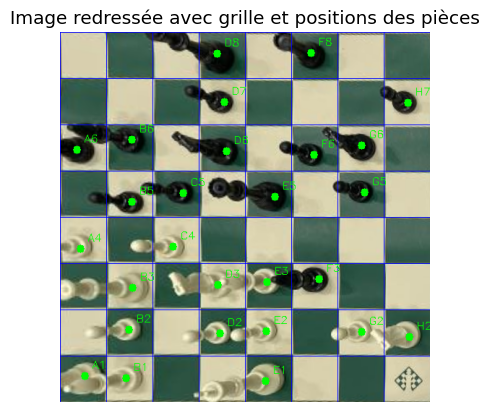

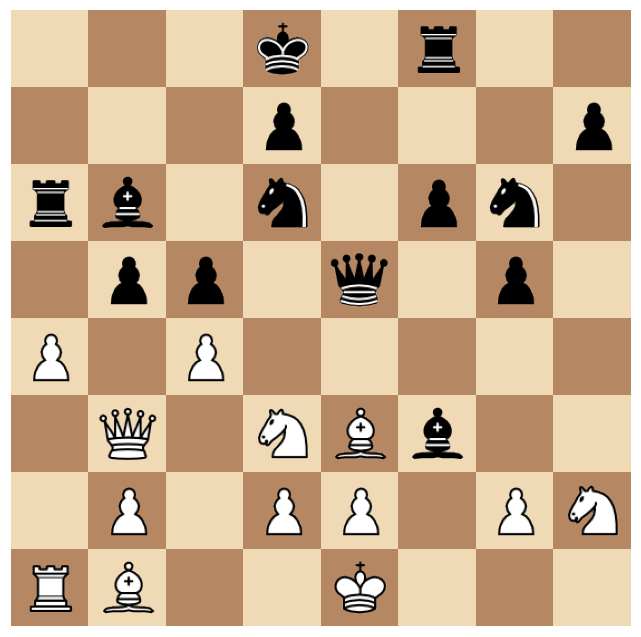

In [13]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline

def parse_fen(fen):
    rows = fen.strip().split(' ')[0].split('/')
    board = []
    for row in rows:
        board_row = []
        for char in row:
            if char.isdigit():
                board_row.extend([' '] * int(char))
            else:
                board_row.append(char)
        board.append(board_row)
    return board

def plot_chess_board(fen):
    # Analyse de la chaîne FEN
    board = parse_fen(fen)

    # Création de la figure et des axes
    fig, ax = plt.subplots(figsize=(8,8))

    # Configuration des limites de l'axe et suppression des axes
    ax.set_xlim(0,8)
    ax.set_ylim(0,8)
    ax.axis('off')

    # Couleurs des cases
    light_color = '#F0D9B5'  # Couleur des cases claires
    dark_color = '#B58863'   # Couleur des cases sombres

    # Dessin de l'échiquier
    for i in range(8):
        for j in range(8):
            color = light_color if (i + j) % 2 == 0 else dark_color
            square = plt.Rectangle((j, 7 - i), 1, 1, facecolor=color)
            ax.add_patch(square)

    # Correspondance entre les pièces et les images
    piece_images = {
        'P': 'wp.png', 'N': 'wn.png', 'B': 'wb.png', 'R': 'wr.png',
        'Q': 'wq.png', 'K': 'wk.png', 'p': 'bp.png', 'n': 'bn.png',
        'b': 'bb.png', 'r': 'br.png', 'q': 'bq.png', 'k': 'bk.png'
    }

    # Placement des pièces sur l'échiquier
    for i in range(8):
        for j in range(8):
            piece = board[i][j]
            if piece != ' ':
                img_path = os.path.join('chess_pieces', piece_images.get(piece))
                if os.path.exists(img_path):
                    img = mpimg.imread(img_path)
                    imagebox = OffsetImage(img, zoom=0.8)
                    ab = AnnotationBbox(imagebox, (j + 0.5, 7 - i + 0.5), frameon=False)
                    ax.add_artist(ab)
                else:
                    print(f"Image non trouvée pour la pièce: {piece} à la position ({i}, {j})")

    # Afficher l'échiquier
    plt.show()

# Exemple d'utilisation
plot_chess_board(fen)

# Partie 7 : Mettre la partie sur Lichess

In [14]:
# import webbrowser

# def open_chess_position(fen, site="lichess"):
#     # Remplacer les espaces par des tirets pour respecter le format d'URL
#     fen_url = fen.replace(" ", "_")
    
#     if site == "lichess":
#         # Format de l'URL pour Lichess
#         url = f"https://lichess.org/analysis/standard/{fen_url}"
#     elif site == "chess.com":
#         # URL pour accéder au board d'analyse sur Chess.com
#         url = "https://www.chess.com/analysis"
#     else:
#         raise ValueError("Site non pris en charge. Choisissez 'lichess' ou 'chess.com'.")

#     # Ouvre l'URL dans le navigateur
#     webbrowser.open(url)

#     if site == "chess.com":
#         print("Pour Chess.com, collez la chaîne FEN dans l'outil d'analyse.")

# # Exemple de FEN
# fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
# open_chess_position(fen, site="lichess")

# Partie 8 : Stockfish

In [15]:
from stockfish import Stockfish

# Remplace 'path_to_stockfish_executable' par le chemin de ton fichier Stockfish
stockfish = Stockfish(path="stockfish/stockfish-windows-x86-64.exe")

# Définir la position en FEN
stockfish.set_fen_position(fen)

# Meilleur coup pour les Blancs
stockfish.set_fen_position(fen.replace(" b ", " w "))  # Forcer les Blancs à jouer
best_move_white = stockfish.get_best_move()

# Meilleur coup pour les Noirs
stockfish.set_fen_position(fen.replace(" w ", " b "))  # Forcer les Noirs à jouer
best_move_black = stockfish.get_best_move()

print("Le meilleur coup pour les Blancs est :", best_move_white)
print("Le meilleur coup pour les Noirs est :", best_move_black)


Le meilleur coup pour les Blancs est : d3e5
Le meilleur coup pour les Noirs est : e5h2


# Partie 9 : Trouver la position du meilleur coup sur l'image de base 

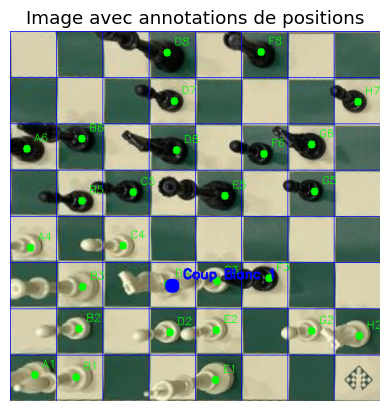

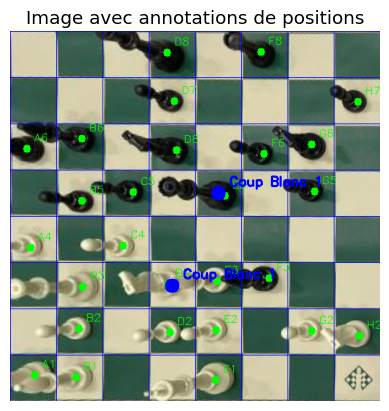

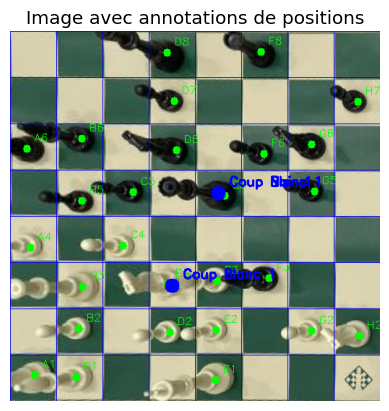

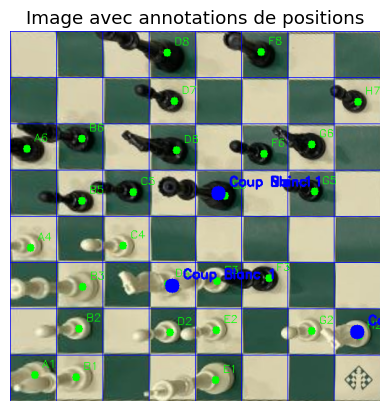

In [16]:
def trouver_coordonnees_case(case, output_size):
    # Taille de chaque case de la grille
    square_size = output_size // 8
    
    # Décoder la colonne et la ligne de la case échiquier (par exemple, 'e4')
    col = ord(case[0].upper()) - 65  # 'A' -> 0, 'B' -> 1, ..., 'H' -> 7
    row = 8 - int(case[1])  # 8 -> 0, 7 -> 1, ..., 1 -> 7
    
    # Calculer les coordonnées x, y
    x = col * square_size
    y = row * square_size
    
    # On les met au milieu de la case
    x = x + square_size // 2
    y = y + square_size // 2
    return (x, y)

def appliquer_inverse_transformations(coordonnees, center, angle_rotation, M):
    x, y = coordonnees
    
    # Étape 1 : Appliquer la rotation inverse
    M_rotation_inv = cv2.getRotationMatrix2D(center, -angle_rotation, 1)  # -angle pour l’inversion
    coord_homogeneous = np.array([x, y, 1])  # Coordonnées homogènes
    coord_rotated = np.dot(M_rotation_inv, coord_homogeneous.T)  # Appliquer la rotation inverse
    
    # Étape 2 : Appliquer la transformation de perspective inverse
    M_inv = np.linalg.inv(M)
    coords = np.array([[coord_rotated[0], coord_rotated[1]]], dtype="float32")
    coords_perspective_inv = cv2.perspectiveTransform(np.array([coords]), M_inv)[0][0]
    
    return (coords_perspective_inv[0], coords_perspective_inv[1])

def convert_best_moves_to_original_image_coordinates(best_move_white, best_move_black, center, angle_rotation, M_perspective, output_size):
    # Traitement du coup des pièces blanches
    white_case_previous_position = best_move_white[:2]
    white_case_next_position = best_move_white[2:]
    
    # On doit remmettre ces coordonnées dans le référentiel de l'image originale, OR on a fait deux transformations (homographie + rotation)
    # Etape 1: Annuler la rotation
    coordonnees_white_previous = trouver_coordonnees_case(white_case_previous_position, output_size)
    afficher_position(image_tournee, [coordonnees_white_previous], label="Coup Blanc")
    coordonnees_white_previous_on_original = appliquer_inverse_transformations(coordonnees_white_previous, center, angle_rotation, M_perspective)
    
    # Etape 2 : Annuler l'homographie
    coordonnees_white_next = trouver_coordonnees_case(white_case_next_position, output_size)
    afficher_position(image_tournee, [coordonnees_white_next], label="Coup Blanc")
    coordonnees_white_next_on_original = appliquer_inverse_transformations(coordonnees_white_next, center, angle_rotation, M_perspective)


    # Traitement du coup des pièces noires
    black_case_previous_position = best_move_black[:2]
    black_case_next_position = best_move_black[2:]
    
    coordonnees_black_previous = trouver_coordonnees_case(black_case_previous_position, output_size)
    afficher_position(image_tournee, [coordonnees_black_previous], label="Coup Noir")
    coordonnees_black_previous_on_original = appliquer_inverse_transformations(coordonnees_black_previous, center, angle_rotation, M_perspective)
    
    coordonnees_black_next = trouver_coordonnees_case(black_case_next_position, output_size)
    afficher_position(image_tournee, [coordonnees_black_next], label="Coup Noir")
    coordonnees_black_next_on_original = appliquer_inverse_transformations(coordonnees_black_next, center, angle_rotation, M_perspective)
    
    return {
        "white": (coordonnees_white_previous_on_original, coordonnees_white_next_on_original),
        "black": (coordonnees_black_previous_on_original, coordonnees_black_next_on_original)
    }

# Exemple d'utilisation
coordonnees_best_moves = convert_best_moves_to_original_image_coordinates(best_move_white, best_move_black, center, angle, M, output_size)


In [17]:
def place_best_move_on_image(image, best_move_white_coordinates, best_move_black_coordinates):
    # Fonction pour dessiner le déplacement sur l'image
    def dessiner_deplacement(image, coordonnees_previous_position_on_original_image, coordonnees_next_position_on_original_image, color):
        
        # Dessiner la position initiale (cercle)
        cv2.circle(image, 
                   (int(coordonnees_previous_position_on_original_image[0]), int(coordonnees_previous_position_on_original_image[1])), 
                   radius=5, 
                   color=color,  # Couleur spécifique pour chaque pièce
                   thickness=-1)

        # Dessiner la position finale (cercle)
        cv2.circle(image, 
                   (int(coordonnees_next_position_on_original_image[0]), int(coordonnees_next_position_on_original_image[1])), 
                   radius=5, 
                   color=color,  
                   thickness=-1)

        # Dessiner une flèche de la position initiale vers la position finale
        cv2.arrowedLine(image, 
                        (int(coordonnees_previous_position_on_original_image[0]), int(coordonnees_previous_position_on_original_image[1])), 
                        (int(coordonnees_next_position_on_original_image[0]), int(coordonnees_next_position_on_original_image[1])), 
                        color=color,  
                        thickness=3, 
                        tipLength=0.2)  # Taille de la pointe de la flèche
    # Traiter le coup des pièces blanches avec la couleur bleue
    dessiner_deplacement(image, best_move_white_coordinates[0], best_move_white_coordinates[1], color=(255, 0, 0))  # Bleu

    # Traiter le coup des pièces noires avec la couleur rouge
    dessiner_deplacement(image, best_move_black_coordinates[0], best_move_black_coordinates[1], color=(0, 0, 255))  # Rouge

    # Retourner l'image avec les annotations
    return image

# Utilisation de la fonction pour dessiner les deux coups
image_annotated = place_best_move_on_image(cv2.imread(img_path), coordonnees_best_moves["white"], coordonnees_best_moves["black"])
cv2.imshow("Image avec le déplacement", image_annotated)
cv2.waitKey(0)
cv2.destroyAllWindows()
